# Import the necessary Libraries

In [2]:
import os 
import itertools

import numpy as np 
import pandas as pd 

import seaborn as sns 
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
 
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [3]:
from zipfile import ZipFile
 
data_path = 'lung-and-colon-cancer-histopathological-images.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


# Data Visualization

In [4]:
import os
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_aca', 'lung_n', 'lung_scc']

##### These are the three classes that we have here.

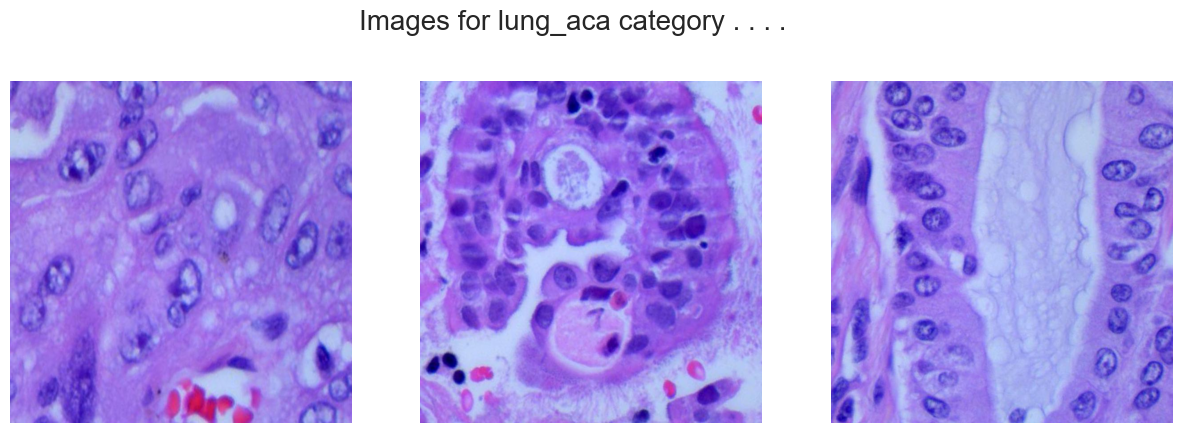

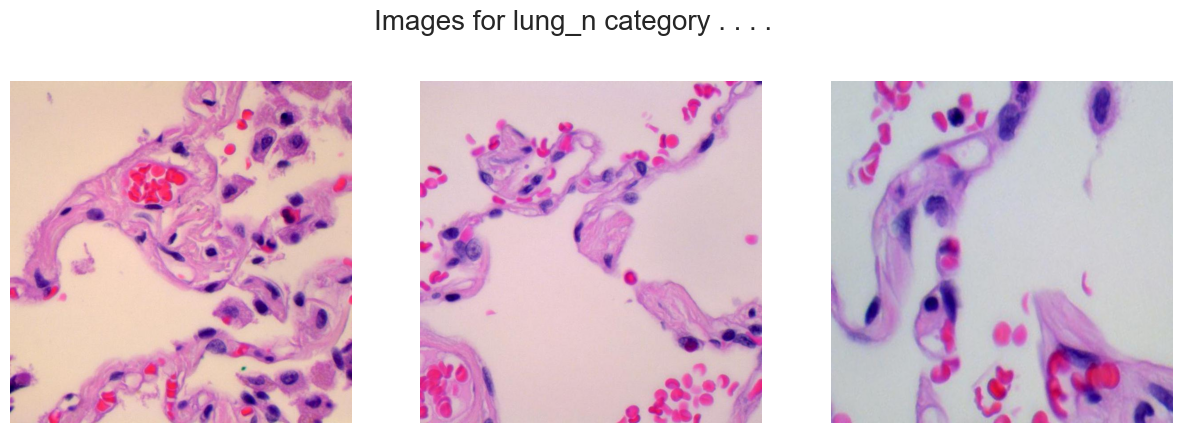

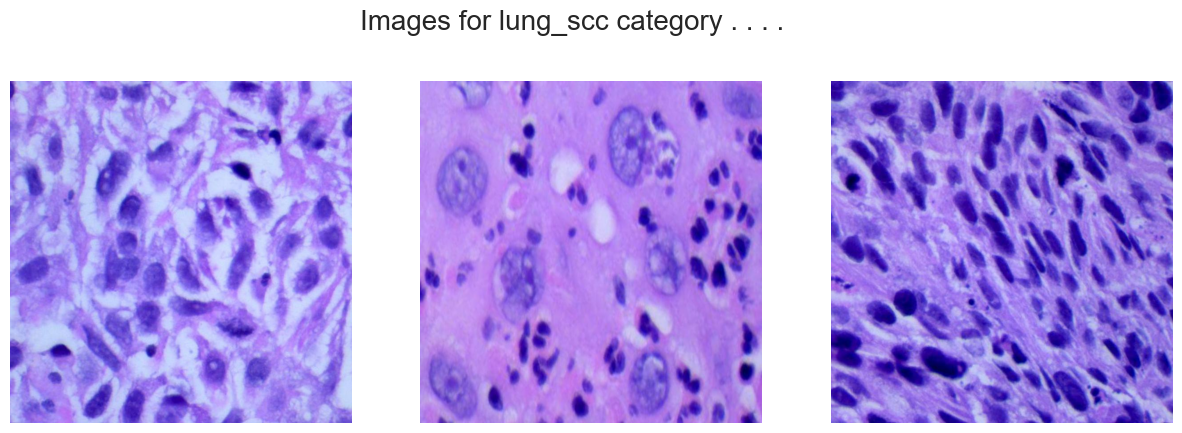

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

# Data Preparation for Training

##### In this section, we will convert the given images into NumPy arrays of their pixels after resizing them because training a Deep Neural Network on large-size images is highly inefficient in terms of computational cost and time.

##### For this purpose, we will use the OpenCV library and Numpy library of python to serve the purpose. Also, after all the images are converted into the desired format we will split them into training and validation data so, that we can evaluate the performance of our model.

In [6]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [7]:
from glob import glob
import cv2
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

#### One hot encoding will help us to train a model which can predict soft probabilities of an image being from each class with the highest probability for the class to which it really belongs.

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


#### In this step, we will achieve the shuffling of the data automatically because the train_test_split function split the data randomly in the given ratio.

# Model Development

#### From this step onward we will use the TensorFlow library to build our CNN model. Keras framework of the tensor flow library contains all the functionalities that one may need to define the architecture of a Convolutional Neural Network and train it on the data.

In [9]:
from keras import layers
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

#### From above we can see the change in the shape of the input image after passing through different layers. The CNN model we have developed contains about 33.6 Million parameters. This huge number of parameters and complexity of the model is what helps to achieve a high-performance model which is being used in real-life applications.

In [11]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Callback

#### Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases learning rate further. Even then if model performance is not improving then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

#### Now we will train our model:

In [13]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.7880 - loss: 0.4958 - val_accuracy: 0.4723 - val_loss: 6.2484 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.9033 - loss: 0.2359 - val_accuracy: 0.3453 - val_loss: 9.8528 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - accuracy: 0.9329 - loss: 0.1722 - val_accuracy: 0.7543 - val_loss: 0.7378 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 467s 2s/step - accuracy: 0.9419 - loss: 0.1448 - val_accuracy: 0.3707 - val_loss: 5.6393 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9486 - loss: 0.1311
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.9486 - loss: 0.1311 - val_accuracy: 0.7227 - val_loss: 1.2331 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.9718 - loss: 0.081

### Let’s visualize the training and validation accuracy with each epoch.

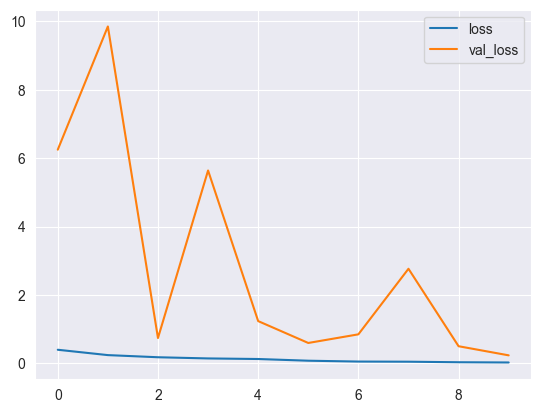

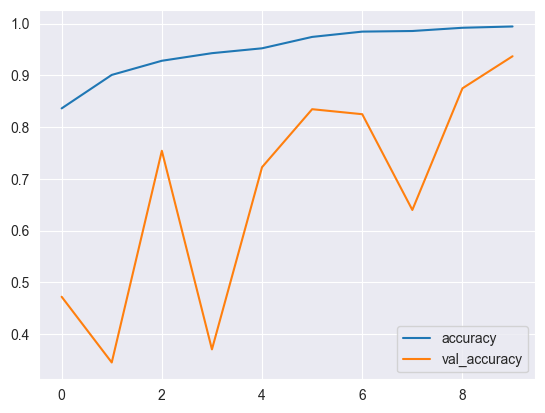

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

#### From the above graphs, we can certainly say that the model has not overfitted the training data as the difference between the training and validation accuracy is very low.

# Model Evaluation

#### Now as we have our model ready let’s evaluate its performance on the validation data using different metrics. For this purpose, we will first predict the class for the validation data using this model and then compare the output with the true labels.

In [15]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step


#### Let’s draw the confusion metrics and classification report using the predicted labels and the true labels.

In [16]:
from sklearn import metrics
metrics.confusion_matrix(Y_val, Y_pred)

array([[907,   1,  79],
       [ 17, 959,   1],
       [ 91,   0, 945]], dtype=int64)

In [17]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.89      0.92      0.91       987
      lung_n       1.00      0.98      0.99       977
    lung_scc       0.92      0.91      0.92      1036

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



# Conclusion:

#### Indeed the performance of our simple CNN model is very good as the f1-score for each class is above 0.90 which means our model’s prediction is correct 90% of the time. This is what we have achieved with a simple CNN model what if we use the Transfer Learning Technique to leverage the pre-trained parameters which have been trained on millions of datasets and for weeks using multiple GPUs? It is highly likely to achieve even better performance on this dataset.

